### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler

In [3]:
from constants import FEATURE_COLUMNS, FEATURE_GASES, TARGET_COLUMNS

from metrics import mean_absolute_percentage_error
from load_data import load_data
from nan_processsing import process_na
from modelling import evaluate_training, plot_fitted_values, train_regression
from submission import create_submission

### Load data

In [4]:
train_features = pd.read_csv('data/train_features.csv')
train_targets = pd.read_csv('data/train_targets.csv')

test_features = pd.read_csv('data/test_features.csv')

In [5]:
train_features, train_targets, test_features = load_data()

### EDA

In [6]:
train_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0    2020-01-01 00:00:00  70.855017       NaN       NaN        NaN        NaN   
1    2020-01-01 00:30:00  70.826582       NaN       NaN        NaN        NaN   
2    2020-01-01 01:00:00  70.809637       NaN       NaN        NaN        NaN   
3    2020-01-01 01:30:00  69.994748       NaN       NaN        NaN        NaN   
4    2020-01-01 02:00:00  70.072762       NaN       NaN        NaN        NaN   
...                  ...        ...       ...       ...        ...        ...   
5803 2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852  16.473834   
5804 2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193  16.448487   
5805 2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557  16.500147   
5806 2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673  16.559533   
5807 2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453  16.649167   

       A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN       NaN       NaN       NaN  71.982789  
1           NaN       NaN       NaN       NaN  71.965098  
2           NaN       NaN       NaN       NaN  71.867409  
3           NaN       NaN       NaN       NaN  71.839126  
4           NaN       NaN       NaN       NaN  71.336921  
...         ...       ...       ...       ...        ...  
5803  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [7]:
train_targets

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0    2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1    2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2    2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3    2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4    2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                  ...       ...        ...        ...        ...
5803 2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804 2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805 2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806 2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807 2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [8]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0    2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480  16.632260   
1    2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023  16.651870   
2    2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965  16.710967   
3    2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180  16.683337   
4    2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587  16.663863   
...                  ...        ...       ...       ...        ...        ...   
3979 2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930  17.741460   
3980 2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418  17.449352   
3981 2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323  17.635380   
3982 2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503  17.758833   
3983 2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330  17.772225   

       A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     24.062587  5.696004  4.939430  6.395286  74.273009  
1     24.069800  5.676384  4.911872  6.346957  74.061833  
2     24.106152  5.574873  4.808516  6.242636  73.856268  
3     24.021993  5.514843  4.730887  6.101647  73.750744  
4     24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...       ...       ...       ...        ...  
3979  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

#### Series plotting

In [9]:
def plot_series(df, layout=None, figsize=(15,15)):
    df.plot(kind='line', subplots=True, grid=True, layout=layout, sharex=True, figsize=figsize)

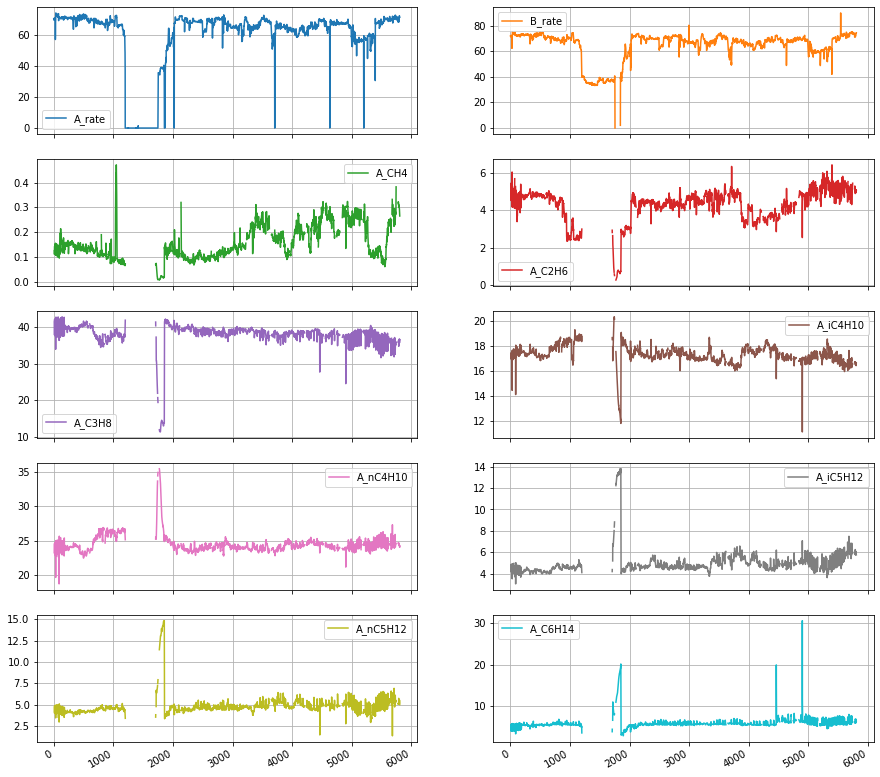

In [10]:
plot_series(train_features[FEATURE_COLUMNS], layout=(5,2))

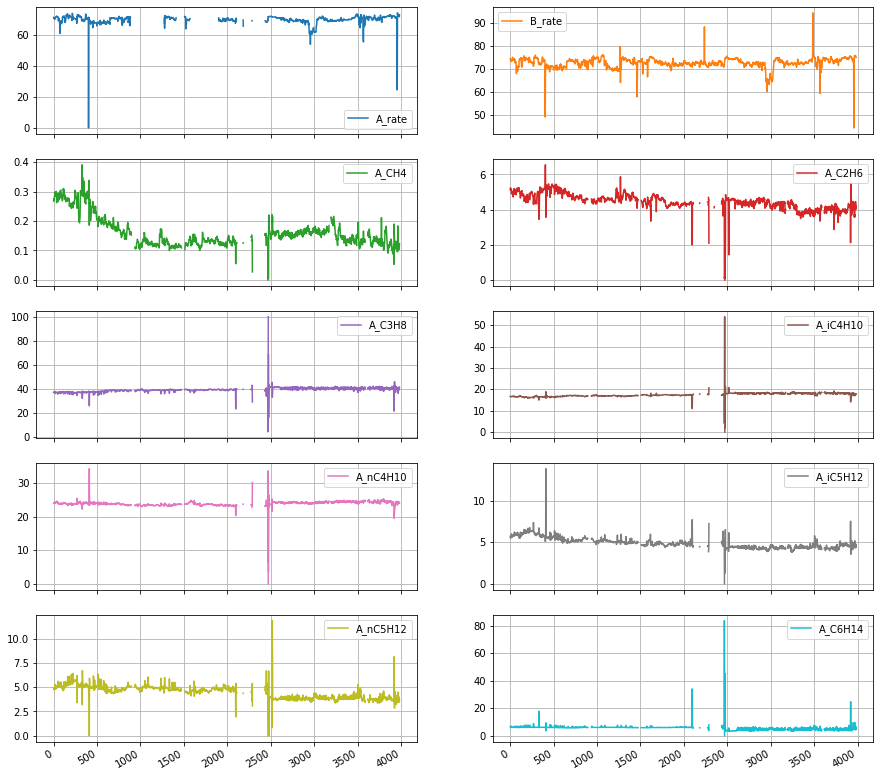

In [11]:
plot_series(test_features[FEATURE_COLUMNS], layout=(5,2))

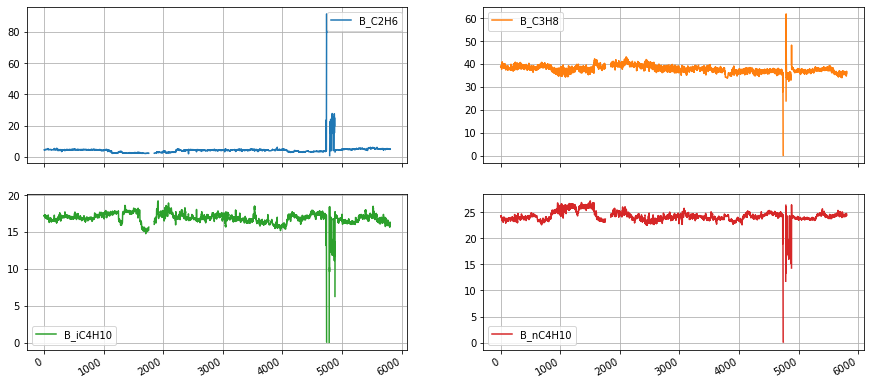

In [12]:
plot_series(train_targets[TARGET_COLUMNS], layout=(2,2), figsize=(15, 7))

#### Train data single x axis

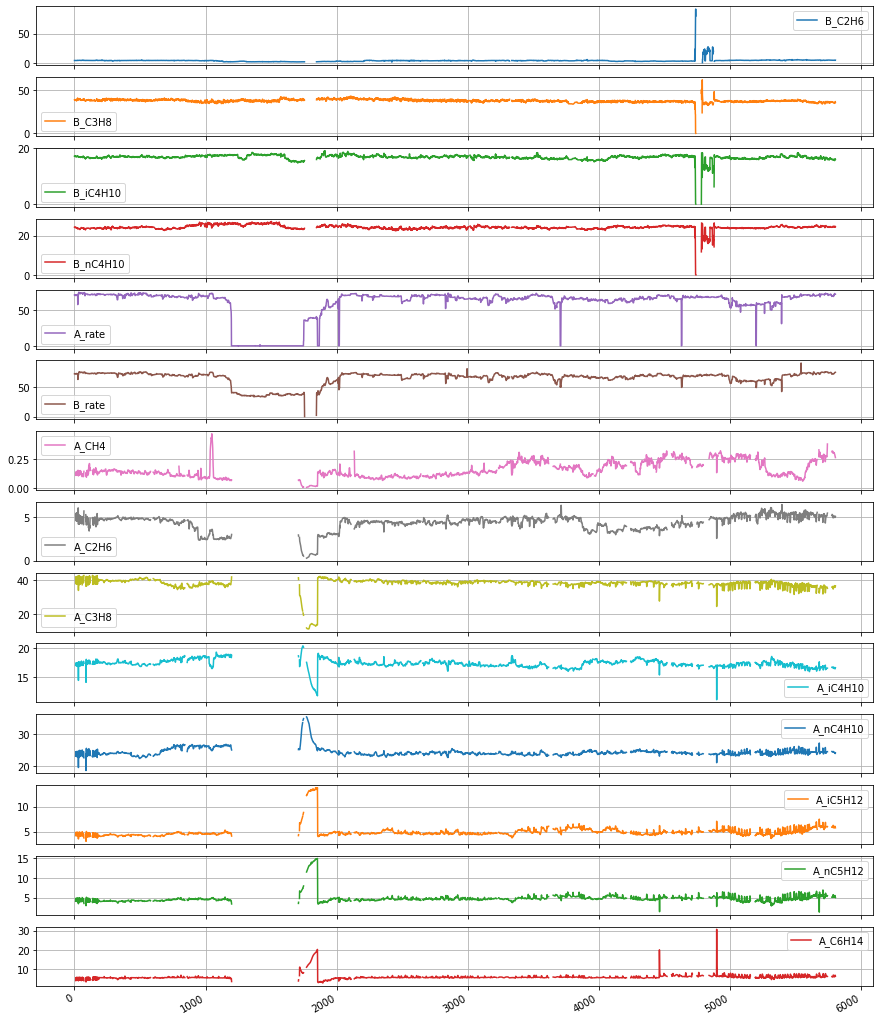

In [13]:
train_df = pd.concat([train_targets, train_features], axis=1, sort=False)
plot_series(train_df[TARGET_COLUMNS + FEATURE_COLUMNS], figsize=(15, 20))

#### Rates visual comparison

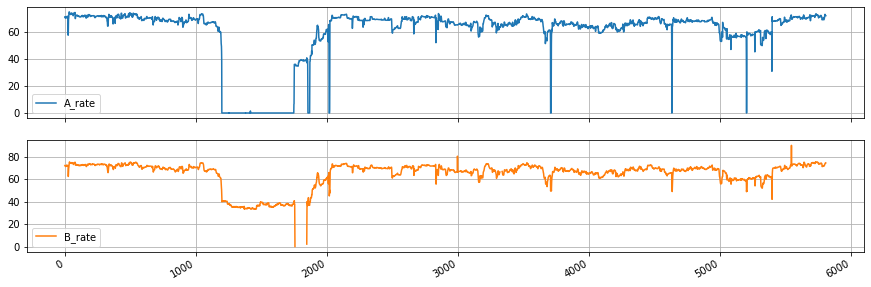

In [14]:
plot_series(train_features[['A_rate', 'B_rate']], figsize=(15,5))

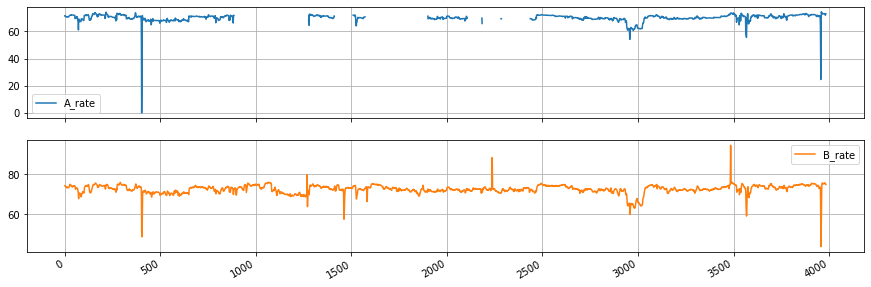

In [15]:
plot_series(test_features[['A_rate', 'B_rate']], figsize=(15,5))

#### Diff of rates

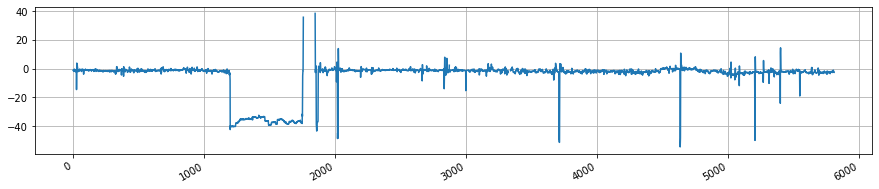

In [16]:
plot_series(train_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

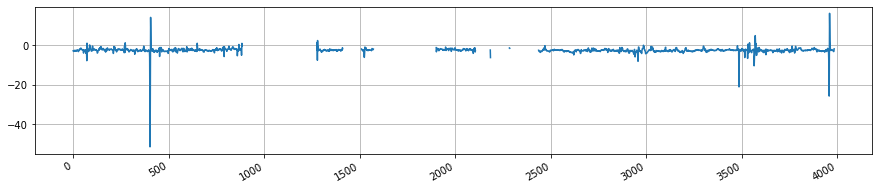

In [17]:
plot_series(test_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

#### Total compaund of gases

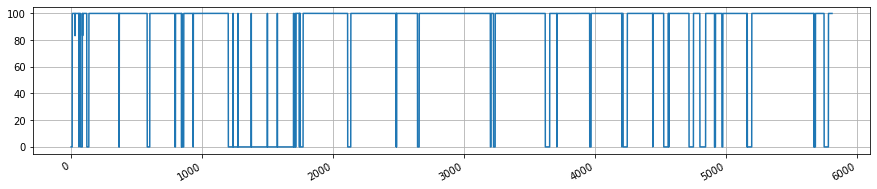

In [18]:
plot_series(train_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

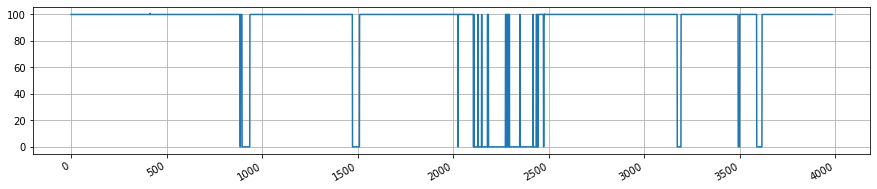

In [19]:
plot_series(test_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

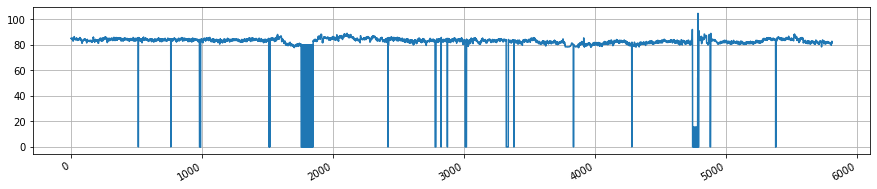

In [20]:
plot_series(train_targets[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

In [21]:
def show_feature_gas_missmatch(df, delta=1):
    gases_sum_df = df[FEATURE_GASES].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    print(gases_sum_df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])
    print('\n')
    print('Missmatch points')
    print(df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])

In [22]:
show_feature_gas_missmatch(train_features)

Missmatch, %
30    83.284430
88    83.281805
dtype: float64


Missmatch points
             timestamp     A_rate     A_CH4   A_C2H6     A_C3H8   A_iC4H10  \
30 2020-01-01 15:00:00  70.825458  0.107138  4.17248  33.986153  14.468455   
88 2020-01-02 20:00:00  71.763913  0.109018  4.47591  36.520668  14.133945   

     A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
30  19.601260  3.508229  3.442494  3.998220  69.986659  
88  18.655932  3.033678  2.954645  3.398009  72.871169  


In [23]:
show_feature_gas_missmatch(test_features)

Missmatch, %
2350     4.148695
2351     4.167530
2475    93.473273
dtype: float64


Missmatch points
               timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  A_iC4H10  \
2350 2020-06-18 23:00:00        NaN       NaN  4.148695        NaN       NaN   
2351 2020-06-18 23:30:00        NaN       NaN  4.167530        NaN       NaN   
2475 2020-06-21 13:30:00  71.936886  0.005033  0.078523  68.149836  2.007036   

      A_nC4H10  A_iC5H12  A_nC5H12    A_C6H14     B_rate  
2350       NaN       NaN       NaN        NaN  71.394341  
2351       NaN       NaN       NaN        NaN  71.518385  
2475   3.73648  1.316491   1.72344  16.456435  74.206501  


In [24]:
def show_target_gas_missmatch(df, target_sum=85, delta=5):
    gases_sum_df = df[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    mask = ((gases_sum_df < target_sum-delta) & (gases_sum_df > 0.0)) | (gases_sum_df > target_sum+delta)
    print(gases_sum_df[mask])
    print('\n')
    print('Missmatch points')
    print(df[mask])

In [25]:
show_target_gas_missmatch(train_targets, delta=10)

Missmatch, %
4748     15.514087
4754     15.514087
4760     15.514087
4766     15.514087
4772     15.514087
4778     15.514087
4782     54.315387
4784    104.705157
4790     51.736505
4881     63.719634
dtype: float64


Missmatch points
               timestamp     B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
4748 2020-04-08 22:00:00  15.455240   0.026142   0.012764   0.019941
4754 2020-04-09 01:00:00  15.455240   0.026142   0.012764   0.019941
4760 2020-04-09 04:00:00  15.455240   0.026142   0.012764   0.019941
4766 2020-04-09 07:00:00  15.455240   0.026142   0.012764   0.019941
4772 2020-04-09 10:00:00  15.455240   0.026142   0.012764   0.019941
4778 2020-04-09 13:00:00  15.455240   0.026142   0.012764   0.019941
4782 2020-04-09 15:00:00  54.095680   0.099073   0.046072   0.074563
4784 2020-04-09 16:00:00  46.368060  46.527746   0.039690  11.769661
4790 2020-04-09 19:00:00   4.325312  23.913870  10.111635  13.385687
4881 2020-04-11 16:30:00   3.492313  39.656436   6.269465  14.301420


#### Measure Nan

In [26]:
train_targets.iloc[1800:1820, :]

timestamp    B_C2H6    B_C3H8  B_iC4H10  B_nC4H10
1800 2020-02-07 12:00:00       NaN       NaN       NaN       NaN
1801 2020-02-07 12:30:00       NaN       NaN       NaN       NaN
1802 2020-02-07 13:00:00       NaN       NaN       NaN       NaN
1803 2020-02-07 13:30:00  2.363416  38.25387  15.61444  23.70408
1804 2020-02-07 14:00:00       NaN       NaN       NaN       NaN
1805 2020-02-07 14:30:00       NaN       NaN       NaN       NaN
1806 2020-02-07 15:00:00       NaN       NaN       NaN       NaN
1807 2020-02-07 15:30:00       NaN       NaN       NaN       NaN
1808 2020-02-07 16:00:00       NaN       NaN       NaN       NaN
1809 2020-02-07 16:30:00  2.363416  38.25387  15.61444  23.70408
1810 2020-02-07 17:00:00       NaN       NaN       NaN       NaN
1811 2020-02-07 17:30:00       NaN       NaN       NaN       NaN
1812 2020-02-07 18:00:00       NaN       NaN       NaN       NaN
1813 2020-02-07 18:30:00       NaN       NaN       NaN       NaN
1814 2020-02-07 19:00:00       NaN       NaN       NaN       NaN
1815 2020-02-07 19:30:00  2.363416  38.25387  15.61444  23.70408
1816 2020-02-07 20:00:00       NaN       NaN       NaN       NaN
1817 2020-02-07 20:30:00       NaN       NaN       NaN       NaN
1818 2020-02-07 21:00:00       NaN       NaN       NaN       NaN
1819 2020-02-07 21:30:00       NaN       NaN       NaN       NaN

In [27]:
train_targets.iloc[4748:4790, :]

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
4748 2020-04-08 22:00:00  15.45524   0.026142   0.012764   0.019941
4749 2020-04-08 22:30:00       NaN        NaN        NaN        NaN
4750 2020-04-08 23:00:00       NaN        NaN        NaN        NaN
4751 2020-04-08 23:30:00       NaN        NaN        NaN        NaN
4752 2020-04-09 00:00:00       NaN        NaN        NaN        NaN
4753 2020-04-09 00:30:00       NaN        NaN        NaN        NaN
4754 2020-04-09 01:00:00  15.45524   0.026142   0.012764   0.019941
4755 2020-04-09 01:30:00       NaN        NaN        NaN        NaN
4756 2020-04-09 02:00:00       NaN        NaN        NaN        NaN
4757 2020-04-09 02:30:00       NaN        NaN        NaN        NaN
4758 2020-04-09 03:00:00       NaN        NaN        NaN        NaN
4759 2020-04-09 03:30:00       NaN        NaN        NaN        NaN
4760 2020-04-09 04:00:00  15.45524   0.026142   0.012764   0.019941
4761 2020-04-09 04:30:00       NaN        NaN        NaN        NaN
4762 2020-04-09 05:00:00       NaN        NaN        NaN        NaN
4763 2020-04-09 05:30:00       NaN        NaN        NaN        NaN
4764 2020-04-09 06:00:00       NaN        NaN        NaN        NaN
4765 2020-04-09 06:30:00       NaN        NaN        NaN        NaN
4766 2020-04-09 07:00:00  15.45524   0.026142   0.012764   0.019941
4767 2020-04-09 07:30:00       NaN        NaN        NaN        NaN
4768 2020-04-09 08:00:00       NaN        NaN        NaN        NaN
4769 2020-04-09 08:30:00       NaN        NaN        NaN        NaN
4770 2020-04-09 09:00:00       NaN        NaN        NaN        NaN
4771 2020-04-09 09:30:00       NaN        NaN        NaN        NaN
4772 2020-04-09 10:00:00  15.45524   0.026142   0.012764   0.019941
4773 2020-04-09 10:30:00       NaN        NaN        NaN        NaN
4774 2020-04-09 11:00:00       NaN        NaN        NaN        NaN
4775 2020-04-09 11:30:00       NaN        NaN        NaN        NaN
4776 2020-04-09 12:00:00       NaN        NaN        NaN        NaN
4777 2020-04-09 12:30:00       NaN        NaN        NaN        NaN
4778 2020-04-09 13:00:00  15.45524   0.026142   0.012764   0.019941
4779 2020-04-09 13:30:00       NaN        NaN        NaN        NaN
4780 2020-04-09 14:00:00       NaN        NaN        NaN        NaN
4781 2020-04-09 14:30:00       NaN        NaN        NaN        NaN
4782 2020-04-09 15:00:00  54.09568   0.099073   0.046072   0.074563
4783 2020-04-09 15:30:00       NaN        NaN        NaN        NaN
4784 2020-04-09 16:00:00  46.36806  46.527746   0.039690  11.769661
4785 2020-04-09 16:30:00       NaN  50.756304  14.245790  18.785004
4786 2020-04-09 17:00:00       NaN  39.447790  18.325854  26.345925
4787 2020-04-09 17:30:00       NaN        NaN        NaN        NaN
4788 2020-04-09 18:00:00       NaN        NaN        NaN        NaN
4789 2020-04-09 18:30:00       NaN        NaN        NaN        NaN

### Fill NA

- gas NaNs (where all NaN and where not all): 
- rates NaNs
- targets Nans

In [28]:
X_train, y_train, X_test = process_na((train_features, train_targets, test_features))

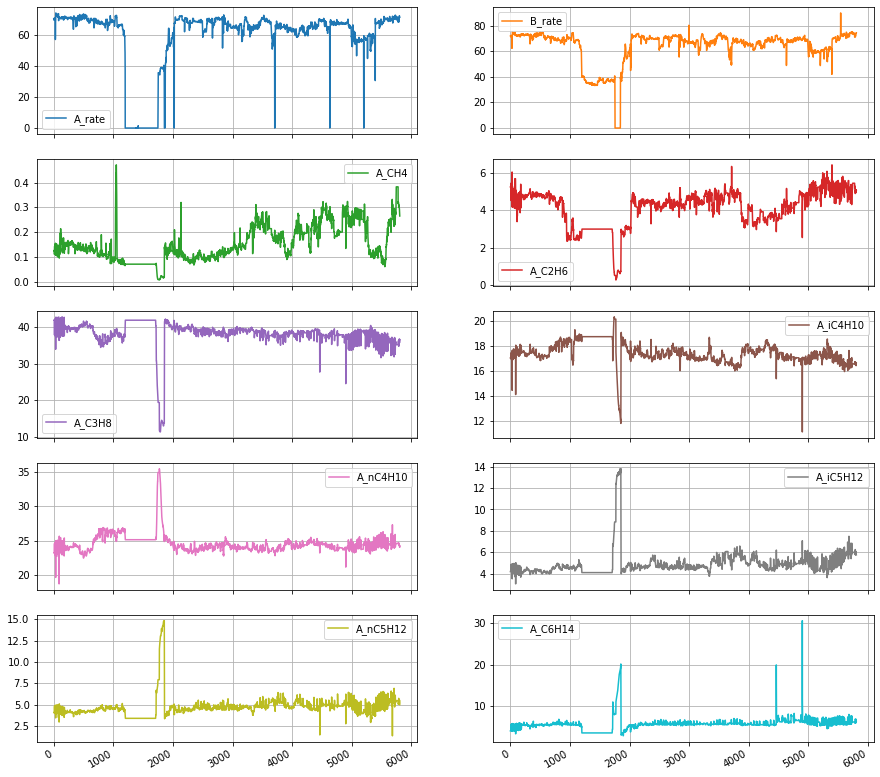

In [29]:
plot_series(X_train[FEATURE_COLUMNS], layout=(5,2))

In [30]:
def train_regression(X_train, y_train):
    model_pipline = Pipeline([
        ("regressor", Ridge())
    ])

    params_grid = {
        "regressor__alpha": np.logspace(-8, 3, num=12, base=10),
        "regressor__fit_intercept": [True, False],
    }

    model = GridSearchCV(model_pipline,
                         params_grid,
                         scoring=make_scorer(r2_score),
                         n_jobs=-1,
                         cv=10,
                         verbose=1,
                         refit=True,
                         return_train_score=True
                         )

    model.fit(X_train, y_train)

    return model

In [45]:
X_train_processed = X_train.copy()
for gas in FEATURE_GASES:
    X_train_processed[f"{gas}_mass"] = X_train[gas]*X_train['A_rate']

y_train_processed = y_train.copy()
for gas in TARGET_COLUMNS:
    y_train_processed[f"{gas}_mass"] = y_train[gas]*X_train['B_rate']

X_test_processed = X_test.copy()
for gas in FEATURE_GASES:
    X_test_processed[f"{gas}_mass"] = X_test[gas]*X_test['A_rate'] 


FEATURE_GASES_MASS = [f"{gas}_mass" for gas in FEATURE_GASES]
TARGET_COLUMNS_MASS = [f"{gas}_mass" for gas in TARGET_COLUMNS]

processed_df = pd.concat([y_train_processed, X_train_processed], axis=1)[FEATURE_GASES + TARGET_COLUMNS + TARGET_COLUMNS_MASS + FEATURE_GASES_MASS]

In [46]:
processed_df

A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12  \
0     0.126244  5.242957  41.941480  17.064213  23.205953  4.184848  4.062079   
1     0.126244  5.242957  41.941480  17.064213  23.205953  4.184848  4.062079   
2     0.126244  5.242957  41.941480  17.064213  23.205953  4.184848  4.062079   
3     0.126244  5.242957  41.941480  17.064213  23.205953  4.184848  4.062079   
4     0.126244  5.242957  41.941480  17.064213  23.205953  4.184848  4.062079   
...        ...       ...        ...        ...        ...       ...       ...   
5803  0.284151  4.936343  35.758852  16.473834  24.318968  6.069360  5.527463   
5804  0.282501  4.960453  35.877193  16.448487  24.074193  5.981357  5.407256   
5805  0.277686  5.013878  36.271557  16.500147  24.010123  5.829363  5.160329   
5806  0.271106  5.080144  36.616673  16.559533  24.008848  5.750492  5.017941   
5807  0.265635  5.069165  36.602453  16.649167  24.150503  5.752792  4.997528   

       A_C6H14    B_C2H6     B_C3H8  ...  B_iC4H10_mass  B_nC4H10_mass  \
0     4.110170  4.561979  39.015486  ...    1241.756379    1749.310804   
1     4.110170  4.550741  39.048915  ...    1239.923110    1745.690583   
2     4.110170  4.506793  38.766378  ...    1234.079926    1741.799936   
3     4.110170  4.584963  39.069360  ...    1236.963509    1734.903640   
4     4.110170  4.607483  38.817579  ...    1220.479662    1715.617995   
...        ...       ...        ...  ...            ...            ...   
5803  6.577563  4.816865  35.539156  ...    1206.958545    1837.549701   
5804  6.915378  4.993286  36.067750  ...    1210.990747    1835.277735   
5805  6.884173  5.101574  36.275040  ...    1208.216565    1826.167519   
5806  6.642076  5.210675  36.872917  ...    1214.127577    1816.263772   
5807  6.459137  5.136487  35.860326  ...    1196.779572    1815.578252   

      A_CH4_mass  A_C2H6_mass  A_C3H8_mass  A_iC4H10_mass  A_nC4H10_mass  \
0       8.945042   371.489783  2971.764273    1209.085124    1644.258215   
1       8.941452   371.340700  2970.571671    1208.599904    1643.598356   
2       8.939313   371.251860  2969.860989    1208.310758    1643.205140   
3       8.836438   366.979432  2935.683333    1194.405316    1624.294861   
4       8.846287   367.388454  2938.955338    1195.736556    1626.105241   
...          ...          ...          ...            ...            ...   
5803   20.461628   355.464743  2574.985289    1186.276343    1751.202327   
5804   20.298902   356.429261  2577.926323    1181.892529    1729.831432   
5805   19.933217   359.912571  2603.691039    1184.434526    1723.525228   
5806   19.443075   364.336450  2626.065169    1187.612357    1721.860416   
5807   19.054066   363.612852  2625.505869    1194.250134    1732.323450   

      A_iC5H12_mass  A_nC5H12_mass  A_C6H14_mass  
0        296.517452     287.818700    291.226165  
1        296.398456     287.703195    291.109292  
2        296.327546     287.634364    291.039647  
3        292.917359     284.324220    287.690314  
4        293.243834     284.641118    288.010963  
...             ...            ...           ...  
5803     437.052948     398.031091    473.648509  
5804     429.785529     388.533948    496.898819  
5805     418.450753     370.425327    494.168443  
5806     412.412308     359.875391    476.354724  
5807     412.649615     358.474283    463.315972  

[5808 rows x 24 columns]

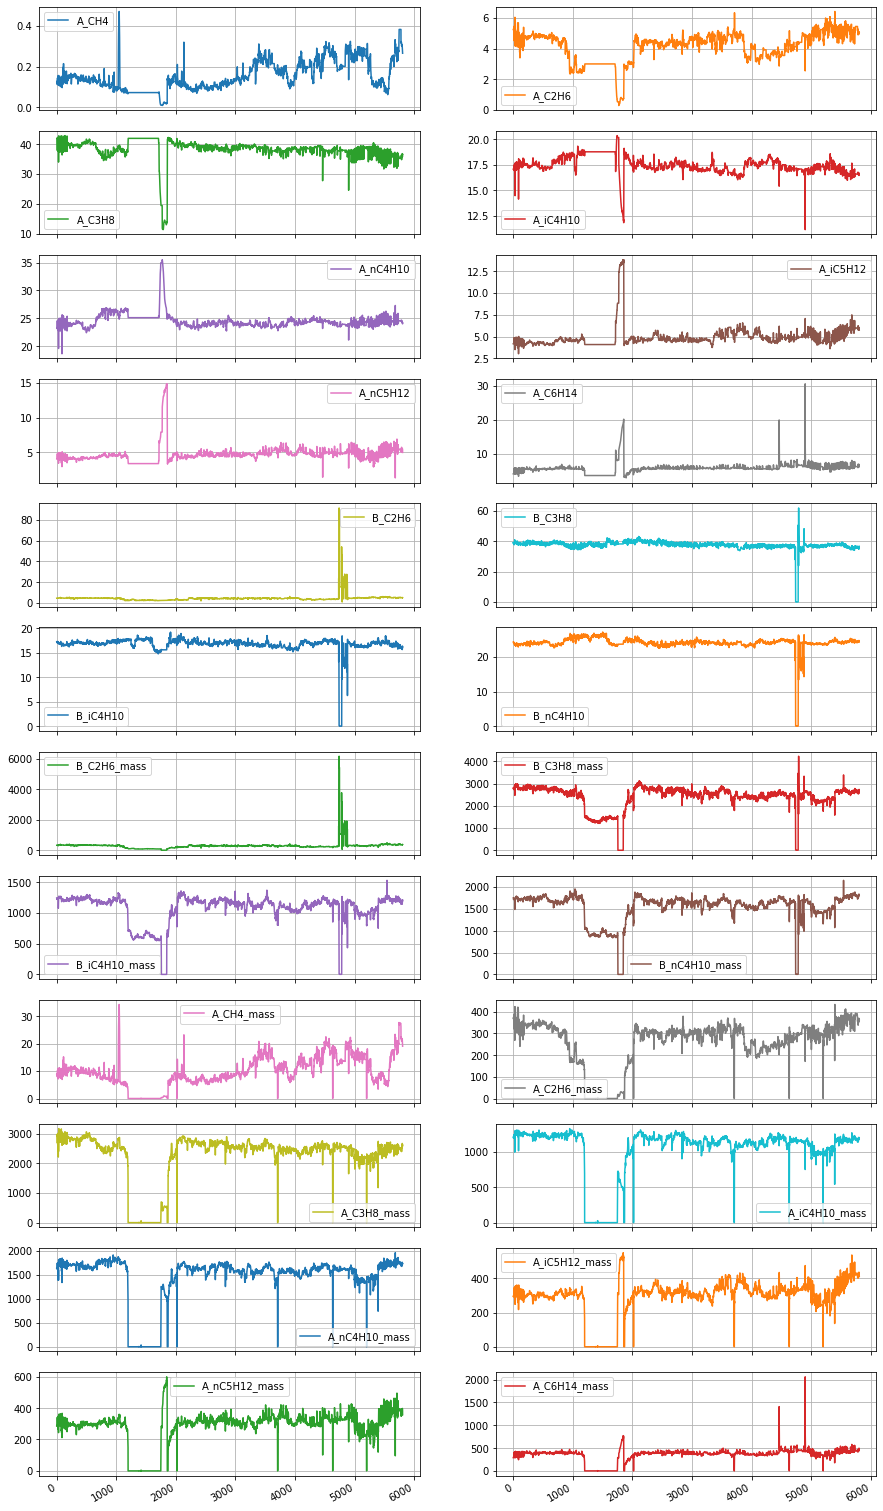

In [48]:
plot_series(processed_df, layout=(12,2),figsize=(15, 30))

In [49]:
processed_df.corr().style.background_gradient(cmap='coolwarm')

In [52]:
X_test_processed[FEATURE_GASES + FEATURE_GASES_MASS].corr().style.background_gradient(cmap='coolwarm')

In [36]:
# 1. модель на этан: линейная либо,
# 2. модель на пропан
# 3. модули на бутаны из модели на пропан (линейно)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.8s finished
MAPE=21.66208561187127


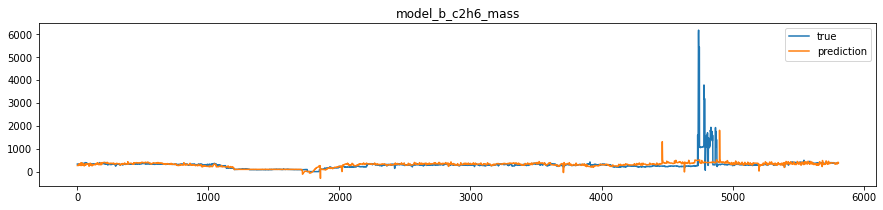

In [53]:
X_masses = processed_df[FEATURE_GASES + FEATURE_GASES_MASS]
y_b_c2h6_mass = processed_df['B_C2H6_mass']

model_b_c2h6_mass = train_regression(X_masses, y_b_c2h6_mass)

b_c2h6_mass_pred = model_b_c2h6_mass.best_estimator_.predict(X_test_processed[FEATURE_GASES + FEATURE_GASES_MASS])
b_c2h6_pred = b_c2h6_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_c2h6_mass.best_estimator_, X_masses, y_b_c2h6_mass, f'model_b_c2h6_mass')

model_pred = model_b_c2h6_mass.best_estimator_.predict(X_masses)
y_true = y_b_c2h6_mass

mape = mean_absolute_percentage_error(y_true.values, model_pred)
print(f"MAPE={mape}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.3s finished
MAPE=852.658288844759


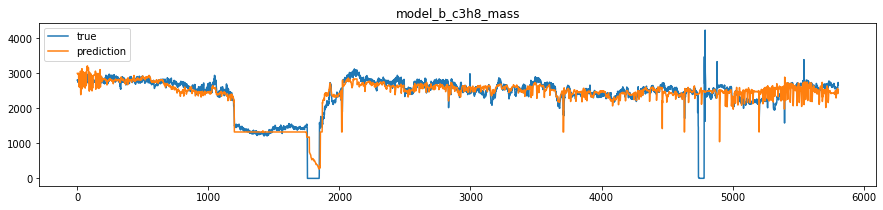

In [38]:
# X_masses = processed_df[['A_C3H8_mass', 'A_CH4_mass']]
X_masses = processed_df[FEATURE_GASES + FEATURE_GASES_MASS]
y_b_c3h8_mass = processed_df['B_C3H8_mass']

model_b_c3h8_mass = train_regression(X_masses, y_b_c3h8_mass)

# b_c3h8_mass_pred = model_b_c3h8_mass.best_estimator_.predict(X_test_processed[['A_C3H8_mass', 'A_CH4_mass']])
b_c3h8_mass_pred = model_b_c3h8_mass.best_estimator_.predict(X_test_processed[FEATURE_GASES + FEATURE_GASES_MASS])
b_c3h8_pred = b_c3h8_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_c3h8_mass.best_estimator_, X_masses, y_b_c3h8_mass, f'model_b_c3h8_mass')

model_pred = model_b_c3h8_mass.best_estimator_.predict(X_masses)
y_true = y_b_c3h8_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.2s finished
MAPE=26.786013150451865


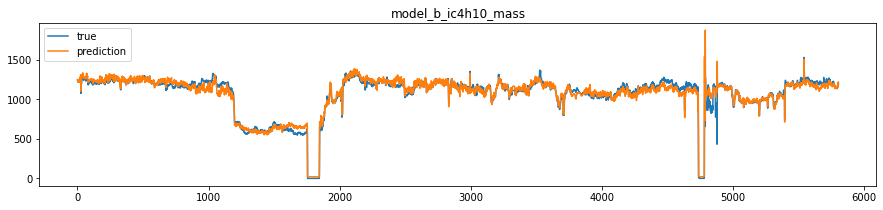

In [39]:
X_masses = y_train_processed['B_C3H8_mass']
y_b_ic4h10_mass = y_train_processed['B_iC4H10_mass']

model_b_ic4h10_mass = train_regression(X_masses.values.reshape(-1,1), y_b_ic4h10_mass)

b_ic4h10_mass_pred = model_b_ic4h10_mass.best_estimator_.predict(b_c3h8_mass_pred.reshape(-1,1))
b_ic4h10_pred = b_ic4h10_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_ic4h10_mass.best_estimator_, X_masses.values.reshape(-1,1), y_b_ic4h10_mass, f'model_b_ic4h10_mass')

model_pred = model_b_ic4h10_mass.best_estimator_.predict(X_masses.values.reshape(-1,1))
y_true = y_b_ic4h10_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.1s finished
MAPE=42.55618208679849


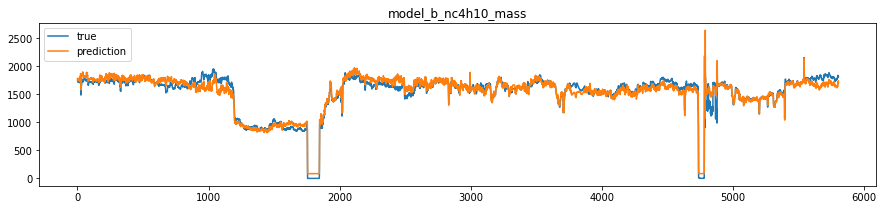

In [40]:
X_masses = y_train_processed['B_C3H8_mass']
y_b_nc4h10_mass = y_train_processed['B_nC4H10_mass']

model_b_nc4h10_mass = train_regression(X_masses.values.reshape(-1,1), y_b_nc4h10_mass)

b_nc4h10_mass_pred = model_b_nc4h10_mass.best_estimator_.predict(b_c3h8_mass_pred.reshape(-1,1))
b_nc4h10_pred = b_nc4h10_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_nc4h10_mass.best_estimator_, X_masses.values.reshape(-1,1), y_b_nc4h10_mass, f'model_b_nc4h10_mass')

model_pred = model_b_nc4h10_mass.best_estimator_.predict(X_masses.values.reshape(-1,1))
y_true = y_b_nc4h10_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

In [41]:
y_preds = [s.values for s in [b_c2h6_pred, b_c3h8_pred, b_ic4h10_pred, b_nc4h10_pred]]
sub = create_submission(X_test["timestamp"], y_preds)

In [42]:
sub

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0    2020-05-01 00:00:00  5.062916  34.429220  15.355051  21.936908
1    2020-05-01 00:30:00  5.021085  34.529978  15.399968  22.001021
2    2020-05-01 01:00:00  5.019837  34.999730  15.606554  22.287979
3    2020-05-01 01:30:00  4.985794  35.517530  15.833830  22.602424
4    2020-05-01 02:00:00  4.936906  35.625669  15.881407  22.668565
...                  ...       ...        ...        ...        ...
3979 2020-07-22 21:30:00  3.682262  39.027373  17.365548  24.696411
3980 2020-07-22 22:00:00  5.185536  35.635691  15.879787  22.649180
3981 2020-07-22 22:30:00  4.429054  37.180256  16.557943  23.588017
3982 2020-07-22 23:00:00  3.945199  38.488541  17.131987  24.381667
3983 2020-07-22 23:30:00  3.926463  39.422526  17.541106  24.945325

[3984 rows x 5 columns]

In [44]:
sub.to_csv(f'submission.csv', index=False)

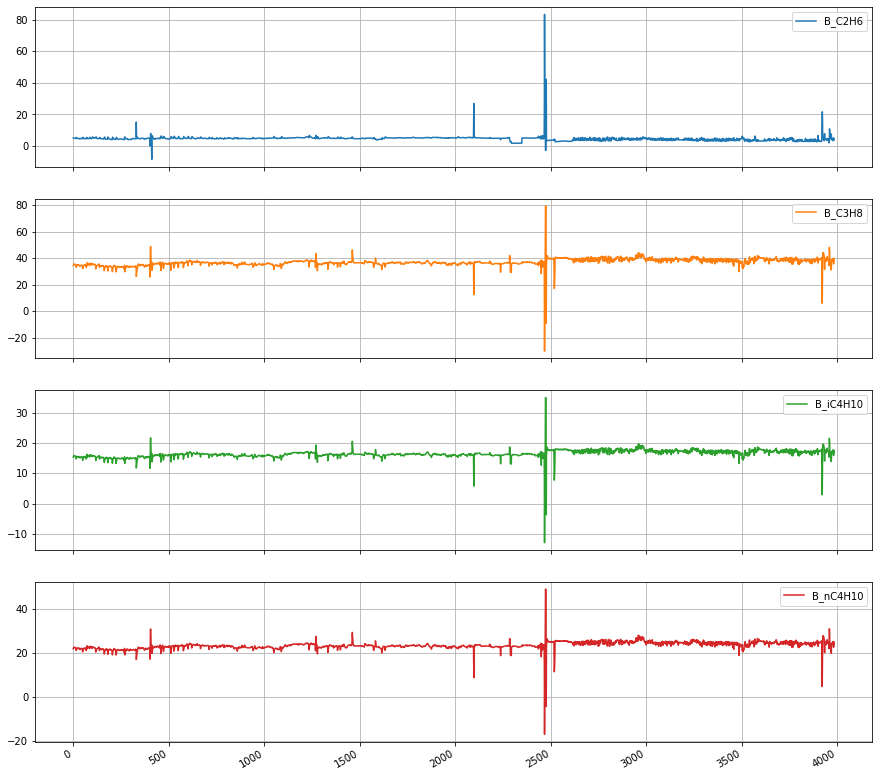

In [43]:
plot_series(sub[TARGET_COLUMNS])